In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# importing the data into arrays
# first column of the data file is phase data
PhaseHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(0))
Phase = np.concatenate((PhaseHalf, PhaseHalf+1))
# second column of the data file is flux data
FluxHalf = np.loadtxt("GD356HSTFUV(1120_1330).dat", usecols=(1))
Flux = np.concatenate((FluxHalf+1, FluxHalf+1))

amplitude = (np.amax(Flux) - np.amin(Flux))/2
meanError = 0.2 * amplitude
Error = [meanError] * len(Flux)

In [3]:
def mean_data(Phase, Flux, Error, bins):

    Phase_split = np.array_split(Phase, bins)
    Flux_split = np.array_split(Flux, bins)
    Error_split = np.array_split(Error, bins)

    meanPhase = [] * bins
    meanFlux = [] * bins
    meanError = [] * bins

    for i in range(bins):

        meanPhase_i = np.mean(Phase_split[i])
        meanFlux_i = np.sum(Flux_split[i] / (Error_split[i]**2))/ np.sum(1/(Error_split[i]**2))

        meanError_i = np.sqrt(1/np.sum(1/(Error_split[i]**2)))

        meanPhase.append(meanPhase_i)
        meanFlux.append(meanFlux_i)
        meanError.append(meanError_i)
        
    return meanPhase, meanFlux, meanError

meanPhase, meanFlux, meanError = mean_data(Phase, Flux, Error, 200)

In [4]:
import numpy as np
import starry
import exoplanet as xo
import pymc3 as pm
import pymc3_ext as pmx
import matplotlib.pyplot as plt
import theano.tensor as tt

starry.config.lazy = True
starry.config.quiet = True

In [5]:
flux = meanFlux
flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

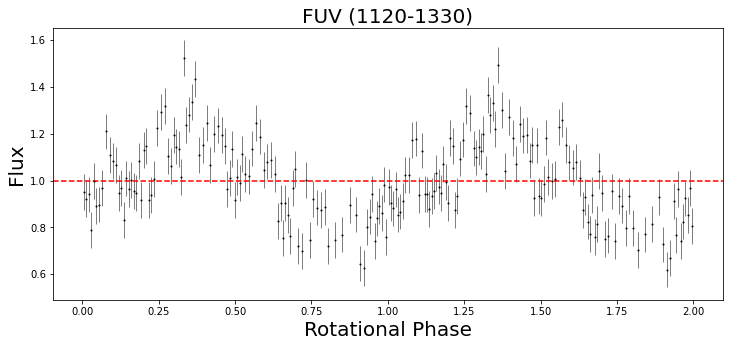

In [6]:
plt.figure(figsize=(12, 5))

plt.title('FUV (1120-1330)', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# Small Radius

In [7]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = 1
    radius = pm.Uniform("radius", lower=0.0, upper=20.0, testval=10.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [8]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius]


message: Optimization terminated successfully.
logp: -192.90426092220866 -> -34.45330073664884


In [10]:
keys = ["radius", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
radius       19.92051
lat          37.00600
lon          49.19279
inc          52.76731


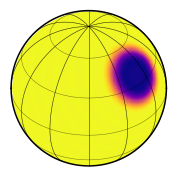

In [11]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=19.92051, lat=37.00600, lon=49.19279)
map.inc = 52.76731
map.show()

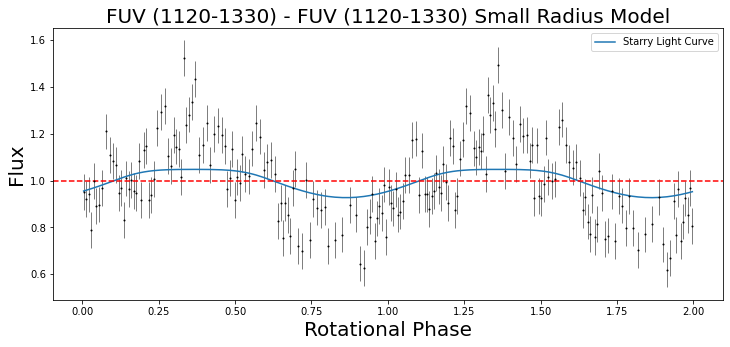

In [12]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120-1330) - FUV (1120-1330) Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# Medium Radius

In [13]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = 1
    radius = pm.Uniform("radius", lower=20.0, upper=60.0, testval=30.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [14]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius]


message: Optimization terminated successfully.
logp: -192.79670878277932 -> 109.16956969049149


In [15]:
keys = ["radius", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
radius       49.51241
lat          64.27801
lon          50.70721
inc          24.65907


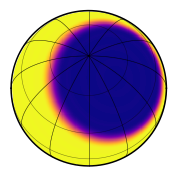

In [16]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=49.51241, lat=64.27801, lon=50.70721)
map.inc = 24.65907
map.show()

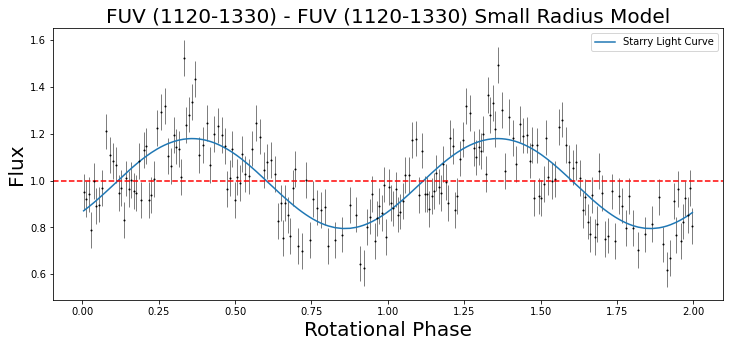

In [17]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120-1330) - FUV (1120-1330) Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# Large Radius

In [18]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = 1
    radius = pm.Uniform("radius", lower=60.0, upper=90.0, testval=80.0)
    lat = pm.Uniform("lat", lower=-90.0, upper=90.0, testval=0.1)
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = pm.Uniform("inc", lower=0.0, upper=90.0, testval=0.1)
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [19]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [inc, lon, lat, radius]


message: Optimization terminated successfully.
logp: -190.32658076578818 -> 109.03055328184277


In [20]:
keys = ["radius", "lat", "lon", "inc"]

param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
radius       84.77820
lat         -69.40016
lon          50.82513
inc          64.14617


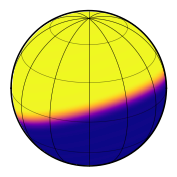

In [21]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=1, radius=84.77820, lat=-69.40016, lon=50.82513)
map.inc = 64.14617
map.show()

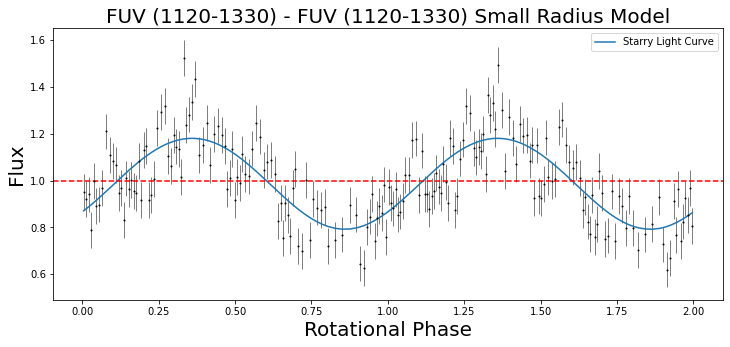

In [22]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('FUV (1120-1330) - FUV (1120-1330) Small Radius Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# TESS - Medium

In [23]:
# importing the data into arrays
# first column of the data file is phase data
TessPhaseHalf = np.loadtxt("GD356allTess.dat", usecols=(0))
TessPhase = np.concatenate((TessPhaseHalf, TessPhaseHalf+1))
# second column of the data file is flux data
TessFluxHalf = np.loadtxt("GD356allTess.dat", usecols=(1))
TessFlux = np.concatenate((TessFluxHalf+1, TessFluxHalf+1))
# third column of the data file is flux error
TessErrorHalf = np.loadtxt("GD356allTess.dat", usecols=(2))
TessError = np.concatenate((TessErrorHalf, TessErrorHalf))

In [24]:
meanPhase, meanFlux, meanError = mean_data(TessPhase, TessFlux, TessError, 200)

In [25]:
flux = meanFlux
flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

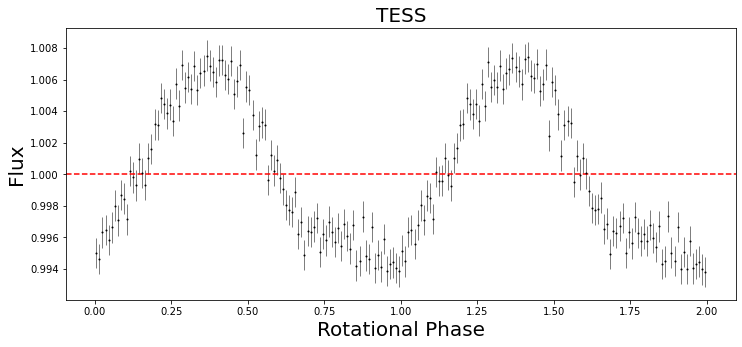

In [26]:
plt.figure(figsize=(12, 5))

plt.title('TESS', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [27]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 49.51241
    lat = 64.27801
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.65907
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [28]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -215328.93168935552 -> 1026.5868005094758


In [29]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.05684
lon          45.33392


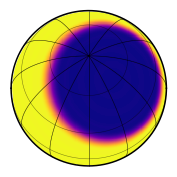

In [30]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.05684, radius=49.51241, lat=64.27801, lon=45.33392)
map.inc = 24.65907
map.show()

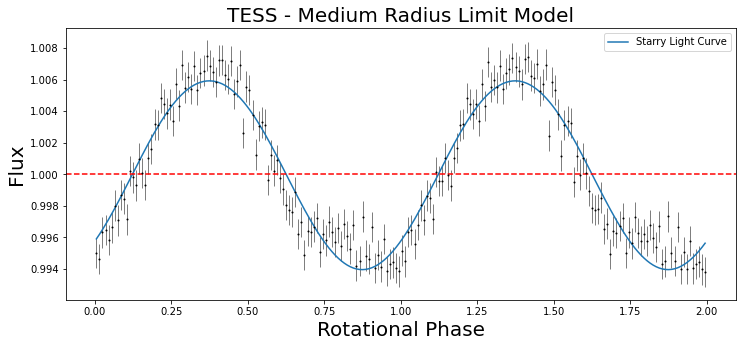

In [33]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('TESS - Medium Radius Limit Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=np.mean(flux), color='r', linestyle='--');

# TESS - Large

In [34]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 84.77820
    lat = -69.40016
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 64.14617
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [35]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -346811.13443105563 -> 1022.3405923878189


In [36]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.04022
lon          45.27630


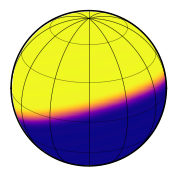

In [37]:
starry.config.lazy = False

map = starry.Map(ydeg=30)
map.spot(contrast=0.04022, radius=84.77820, lat=-69.40016, lon=45.27630)
map.inc = 64.14617
map.show()

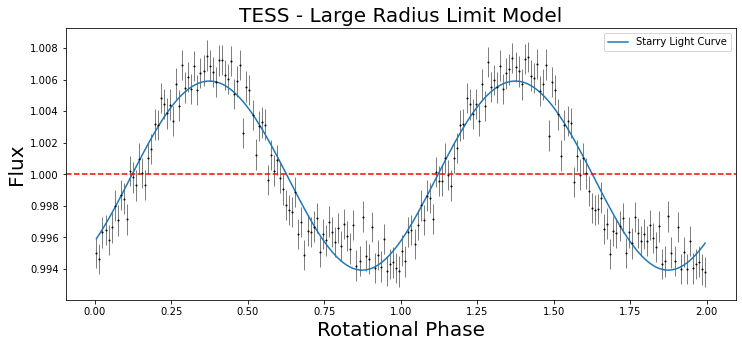

In [39]:
newFlux = map.flux(theta=theta)/np.mean(map.flux(theta=theta))

plt.figure(figsize=(12, 5))

plt.title('TESS - Large Radius Limit Model', fontsize=20)
plt.plot(meanPhase, newFlux, label='Starry Light Curve')
plt.xlabel("Rotational phase", fontsize=20)
plt.legend()
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

# LT - Medium

In [40]:
# importing the data into arrays
# first column of the data file is phase data
LTPhaseHalf = np.loadtxt("GD356LT.dat", usecols=(0))
LTPhase = np.concatenate((LTPhaseHalf, LTPhaseHalf+1))
# second column of the data file is flux data
LTFluxHalf = np.loadtxt("GD356LT.dat", usecols=(1))
LTFlux = np.concatenate((LTFluxHalf+1, LTFluxHalf+1))
# third column of the data file is flux error
LTErrorHalf = np.loadtxt("GD356LT.dat", usecols=(2))
LTError = np.concatenate((LTErrorHalf, LTErrorHalf))

In [41]:
meanPhase, meanFlux, meanError = mean_data(LTPhase, LTFlux, LTError, 200)

In [42]:
flux = meanFlux
flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

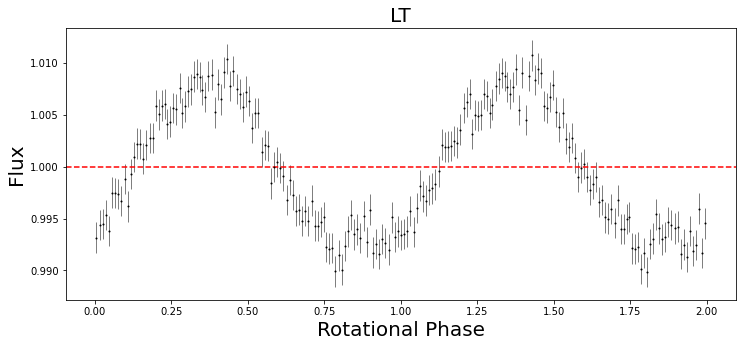

In [43]:
plt.figure(figsize=(12, 5))

plt.title('LT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [44]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 49.51241
    lat = 64.27801
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.65907
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [45]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -88729.79487799427 -> 1012.5970782495025


In [46]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.07610
lon          48.92666


# LT - Large

In [50]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 84.77820
    lat = -69.40016
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 64.14617
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [51]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Desired error not necessarily achieved due to precision loss.
logp: -144086.63693675507 -> 1010.2428698827495


In [52]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.05419
lon          48.91443


# PTO - Medium

In [53]:
# importing the data into arrays
# first column of the data file is phase data
PTO_PhaseHalf = np.loadtxt("GD356PTO.dat", usecols=(0))
PTO_Phase = np.concatenate((PTO_PhaseHalf, PTO_PhaseHalf+1))
# second column of the data file is flux data
PTO_FluxHalf = np.loadtxt("GD356PTO.dat", usecols=(1))
PTO_Flux = np.concatenate((PTO_FluxHalf+1, PTO_FluxHalf+1))
# third column of the data file is flux error
PTO_ErrorHalf = np.loadtxt("GD356PTO.dat", usecols=(2))
PTO_Error = np.concatenate((PTO_ErrorHalf, PTO_ErrorHalf))

In [54]:
meanPhase, meanFlux, meanError = mean_data(PTO_Phase, PTO_Flux, PTO_Error, 200)

In [55]:
flux = meanFlux
flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

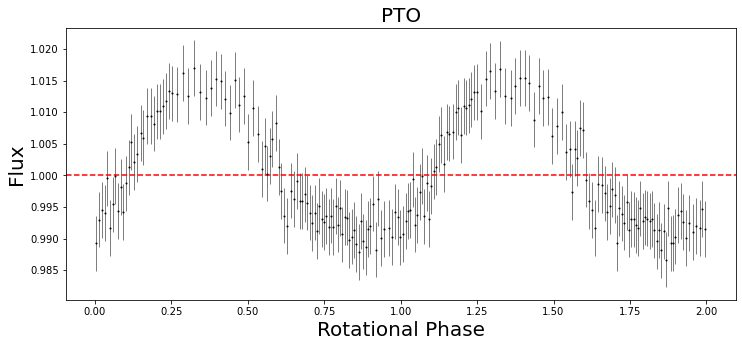

In [56]:
plt.figure(figsize=(12, 5))

plt.title('PTO', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [57]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 49.51241
    lat = 64.27801
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.65907
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [58]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -8442.61543417669 -> 857.9643166891922


In [59]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.11093
lon          51.63636


# PTO - Large

In [60]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 84.77820
    lat = -69.40016
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 64.14617
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [61]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -14292.858679477082 -> 856.972126966428


In [62]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.07977
lon          51.58612


# WHT

In [63]:
# importing the data into arrays
# first column of the data file is phase data
WHT_PhaseHalf = np.loadtxt("GD356WHT.dat", usecols=(0))
WHT_Phase = np.concatenate((WHT_PhaseHalf, WHT_PhaseHalf+1))
# second column of the data file is flux data
WHT_FluxHalf = np.loadtxt("GD356WHT.dat", usecols=(1))
WHT_Flux = np.concatenate((WHT_FluxHalf+1, WHT_FluxHalf+1))
# third column of the data file is flux error
WHT_ErrorHalf = np.loadtxt("GD356WHT.dat", usecols=(2))
WHT_Error = np.concatenate((WHT_ErrorHalf, WHT_ErrorHalf))

In [64]:
meanPhase, meanFlux, meanError = mean_data(WHT_Phase, WHT_Flux, WHT_Error, 200)


In [65]:
flux = meanFlux
flux_err = np.mean(meanError)
t = meanPhase
theta = np.multiply(meanPhase, 360)

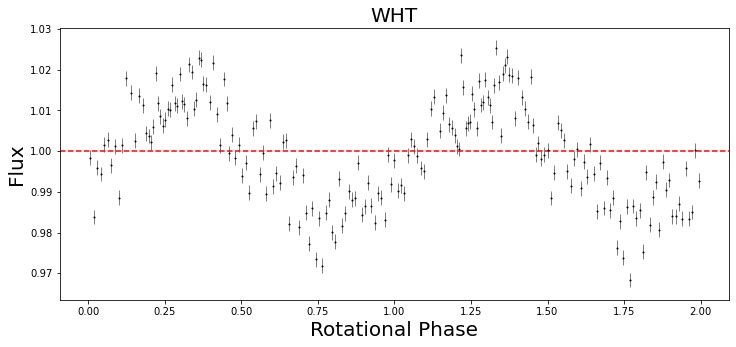

In [66]:
plt.figure(figsize=(12, 5))

plt.title('WHT', fontsize=20)
plt.xlabel("Rotational phase", fontsize=20)
plt.ylabel("Flux", fontsize=20)
plt.errorbar(meanPhase, flux, yerr=flux_err, color='black', marker='.', linestyle='none', markersize=2, elinewidth=0.5)
plt.xlabel('Rotational Phase')
plt.ylabel('Flux')
plt.axhline(y=1, color='r', linestyle='--');

In [67]:
starry.config.lazy = True

with pm.Model() as model:

    # Priors
    contrast = pm.Uniform("contrast", lower=0.0, upper=1.0, testval=0.5)
    radius = 49.51241
    lat = 64.27801
    lon = pm.Uniform("lon", lower=-180.0, upper=180.0, testval=0.1)
    inc = 24.65907
    
    
    # Instantiate the map and add the spot
    map = starry.Map(ydeg=30)
    map.inc = inc
    map.spot(contrast=contrast, radius=radius, lat=lat, lon=lon)

    # Compute the flux model
    flux_model = map.flux(theta=theta)
    flux_model = flux_model/tt.mean(flux_model)
    
    pm.Deterministic("flux_model", flux_model)

    # Save our initial guess
    flux_model_guess = pmx.eval_in_model(flux_model)

    # The likelihood function assuming known Gaussian uncertainty
    pm.Normal("obs", mu=flux_model, sd=flux_err, observed=flux)

In [68]:
with model:
    map_soln = pmx.optimize(start=model.test_point)

optimizing logp for variables: [lon, contrast]


message: Optimization terminated successfully.
logp: -55630.84643602187 -> -84.26803464088394


In [69]:
keys = ["contrast", "lon"]
param = []
print("{0:12s} {1:10s}".format("", "map_soln"))
for key in keys:
    print("{0:10s} {1:10.5f}".format(key, map_soln[key]))
    param.append(map_soln[key])

             map_soln  
contrast      0.13553
lon          68.44675
